**Innovation or Inequality: Do Patent Litigations Lead to Exacerbated
Wealth Inequality?**



Section 1: Introduction


Wealth inequality is a pressing global issue, deepening economic divides and increasing vulnerability to financial shocks. One potential driver of inequality can be patent litigation, particularly its strategic use by dominant firms to suppress competition.

While patents incentivize investment in innovation by guaranteeing financial returns (Dam, 2002), they can also serve as tools for anti-competitive behavior. Large firms often leverage litigation to impose overwhelming legal costs on smaller competitors, ultimately consolidating market power and creating inefficient markets, higher prices, and reduced consumer choice (Drahos & Frankel, 2022). Legal scholarship highlights competing views on the role of intellectual property rights (IPRs) in inequality—Kapczynski (2015) argues that they may reinforce economic divides or function as a means of redistribution. Identifying the dominant mechanism is critical for policymakers seeking to address wealth inequality.

Empirical research on this issue remains inconclusive. While some studies suggest that patent enforcement exacerbates wealth disparities, particularly in innovation-driven economies (Saini & Mehra, 2018), others find contradictory results (Maskus, 2022). Given the global significance of wealth inequality and the complexity of IPR's economic effects, further research is essential.

This study examines the relationship between patent litigation and wealth inequality by analyzing USPTO litigation data alongside Gini coefficient trends in the U.S.. We incorporate key control variables—urbanization, unemployment, and inflation rates—to better isolate the impact of annual patent cases on inequality. Additiionally, a future implementation of an Instrumental Variable Design would key to isolating a reliable causal effect.

----



Section - 2: Data Cleaning and Loading

In [2]:
#importing useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress #for adding trend lines to plots


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Loading CSV files

#assigned data set: Patent Litigations
cases = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/cases.csv")

#y-variable from extternal sourc:e
gini = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/Gini.csv")

#3 new x-variables from external soruces:
urbanization = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/urbanization_rate.csv", on_bad_lines='skip')
unemployment = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/US-Unemployment.csv", on_bad_lines='skip')
inflation= pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/PART1/inflation.csv", header=0,on_bad_lines='skip')

In [4]:
#isolating relevant variables from the raw litigations data
clean_cases = cases[['case_row_id', 'case_number', 'case_cause', 'date_filed', 'date_closed']]
clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


#aggregating cases filed/closed by year
Cases_Closed = clean_cases.groupby('year_closed')['case_number'].nunique().reset_index()
Cases_Closed.columns = ['year', 'Cases Closed']
Cases_Filed = clean_cases.groupby('year_filed')['case_number'].nunique().reset_index()
Cases_Filed.columns = ['year', 'Cases Filed']

#new df containing total cases filed/closed in a given year
annual_cases = pd.merge(Cases_Filed, Cases_Closed, on='year', how='outer').fillna(0)
annual_cases[['Cases Filed', 'Cases Closed']] = annual_cases[['Cases Filed', 'Cases Closed']].astype(float)
annual_cases['year'] = annual_cases['year'].astype(int)

#cleaning unemployment df and computing avg annual unemployment rates for the US
unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int)
clean_unemployment = pd.DataFrame()
clean_unemployment['year'] = unemployment['observation_date'].str[0:4].astype(int).unique()
clean_unemployment['Unemployment Rate'] = (unemployment.groupby(unemployment['observation_date'].str[0:4].astype(int))['UNRATE'].mean().values) /100

#isolating annual gini coeff data for the US
clean_gini = pd.DataFrame()
clean_gini['year'] = gini['observation_date'].str[0:4].astype(int)
clean_gini['Gini Coeff.'] = gini['SIPOVGINIUSA']/100

#converting year columns to rows in clean_urbanization df
clean_urbanization = urbanization.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Urbanization Rate')

clean_urbanization['year'] = pd.to_numeric(clean_urbanization['year'], errors='coerce')
clean_urbanization = clean_urbanization.dropna(subset=['year'])
clean_urbanization['year'] = clean_urbanization['year'].astype(int)
clean_urbanization['Urbanization Rate'] = clean_urbanization['Urbanization Rate'].astype(float) / 100
#isolating US data
clean_urbanization = clean_urbanization[clean_urbanization['Country Name'] == 'United States']
clean_urbanization = clean_urbanization.drop(columns=['Country Name'])
clean_urbanization = clean_urbanization.reset_index()


#converting year columns to rows in clean_inflation df
clean_inflation = inflation.melt(
    id_vars=['Country Name'],
    var_name='year',
    value_name='Inflation Rate')

clean_inflation['year'] = pd.to_numeric(clean_inflation['year'], errors='coerce')
clean_inflation = clean_inflation.dropna(subset=['year'])
clean_inflation['year'] = clean_inflation['year'].astype(int)
clean_inflation['Inflation Rate'] = clean_inflation['Inflation Rate'].astype(float) / 100
#isolating US data
clean_inflation = clean_inflation[clean_inflation['Country Name'] == 'United States']
clean_inflation = clean_inflation.drop(columns=['Country Name'])
clean_inflation = clean_inflation.reset_index()

<ipython-input-4-fe92e2b1ca5a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_closed'] = clean_cases['date_closed'].str[0:4].astype(float)
<ipython-input-4-fe92e2b1ca5a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cases['year_filed'] = clean_cases['date_filed'].str[0:4].astype(float)


In [6]:
#merging all variables into one df
complete_merged = pd.DataFrame()
complete_merged = pd.merge(clean_gini, annual_cases, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_urbanization, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_unemployment, on='year', how='inner')
complete_merged = pd.merge(complete_merged, clean_inflation, on='year', how='inner')
complete_merged = complete_merged.drop(columns=['index_x'])
complete_merged = complete_merged.drop(columns=['index_y'])

In [7]:
#cleaned, merged data table
complete_merged = complete_merged.set_index('year').sort_index()
complete_merged.head()

,Gini Coeff.,Cases Filed,Cases Closed,Urbanization Rate,Unemployment Rate,Inflation Rate
year,,,,,,
1963,0.376,1.0,1.0,0.71134,0.056417,0.012397
1972,0.367,4.0,1.0,0.73623,0.056000,0.032723
1973,0.361,0.0,1.0,0.73633,0.048583,0.061778
1974,0.355,2.0,2.0,0.73643,0.056417,0.110548
1975,0.356,4.0,2.0,0.73653,0.084750,0.091431


---

Section - 3: Summary Statistics

In [8]:
complete_merged.describe()

,Gini Coeff.,Cases Filed,Cases Closed,Urbanization Rate,Unemployment Rate,Inflation Rate
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.389078,1777.725490,1808.215686,0.775468,0.062619,0.038615
std,0.021659,1686.979052,1773.992022,0.033243,0.015735,0.029085
min,0.347000,0.000000,0.000000,0.711340,0.036750,-0.003555
25%,0.373000,52.500000,10.000000,0.742690,0.051708,0.020997
50%,0.400000,1606.000000,1602.000000,0.776360,0.058500,0.030288
75%,0.407000,2722.000000,2774.500000,0.805220,0.072750,0.044992
max,0.415000,5742.000000,6020.000000,0.828730,0.097083,0.135492


The Summary Statistics table shows means, standard deviations, and quartiles for the Gini Coefficient (Y) and five predictor (X) variables over 50 years.

The Gini Coefficient appears left-skewed, with its mean, median (50th), 75th, and 100th percentiles between 0.38–0.41, while the 25th and 0th percentiles are 0.37 and 0.347. This suggests annual increases in inequality have slowed, assuming no overall decline. The low standard deviation (0.02) indicates minor inequality fluctuations, potentially weakening regression power due to low variation.

Cases Filed and Closed have similar distributions, with Cases Closed slightly higher, suggesting a natural lag as cases are filed before resolution. Both variables have insignificant small values (min = 0, 25th percentile < 100 cases). If concentrated in early years, removing them may be useful since they likely have little effect on inequality.

Urbanization rates are normally distributed around 77% (SD = 3.3). Given that urbanization in the U.S. rarely declines, its even distribution suggests linear growth. Since inequality also trends upward, urbanization could be a useful control to isolate litigation effects.

Unemployment has a slight right-skew and high standard deviation, which is expected as unemployment is highly variable, even when annualized. The quartiles suggest slight left-skewness, and its large variation may weaken its effectiveness as a control for inequality.

Inflation has high standard deviation and extreme right-skew, reflecting annualized inflation’s large monthly fluctuations. This volatility may limit its effectiveness as a control for inequality.

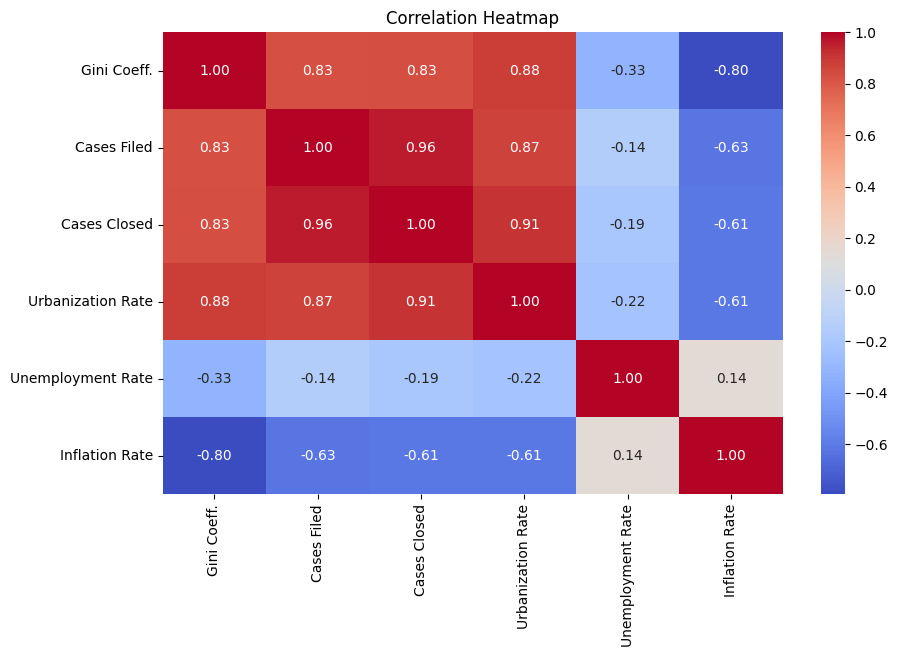

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(complete_merged.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The heat map shows correlations between all dependent and independent variables.

The high positive correlations between cases filed, cases closed, and the Gini coefficient suggest patent litigations may impact inequality, though correlation alone does not imply causation.

Urbanization also has a strong positive correlation with inequality, making it a useful control variable. However, since patent litigations are unlikely to affect urbanization, this correlation likely stems from confounding factors. Including urbanization as a control can help isolate the effect of litigations by reducing omitted variable bias.

Unemployment and inflation both have negative correlations with all other variables. Unemployment's correlations are weak, but inflation shows a strong negative correlation with inequality.

This contradicts intuition, as lower-income groups are expected to be more sensitive to unemployment and inflation. One possible reason is data loss from annualizing variables typically measured quarterly or monthly.

For inflation, one explanation is that during high-inflation years, the Fed raises interest rates, reducing capital returns. This may narrow the income gap if interest rate effects on the wealthy outweigh inflation’s impact on the poor. However, confounding factors prevent drawing reliable conclusions.

Section - 4: Data Visualizations

In [10]:
complete_merged.head()

,Gini Coeff.,Cases Filed,Cases Closed,Urbanization Rate,Unemployment Rate,Inflation Rate
year,,,,,,
1963,0.376,1.0,1.0,0.71134,0.056417,0.012397
1972,0.367,4.0,1.0,0.73623,0.056000,0.032723
1973,0.361,0.0,1.0,0.73633,0.048583,0.061778
1974,0.355,2.0,2.0,0.73643,0.056417,0.110548
1975,0.356,4.0,2.0,0.73653,0.084750,0.091431


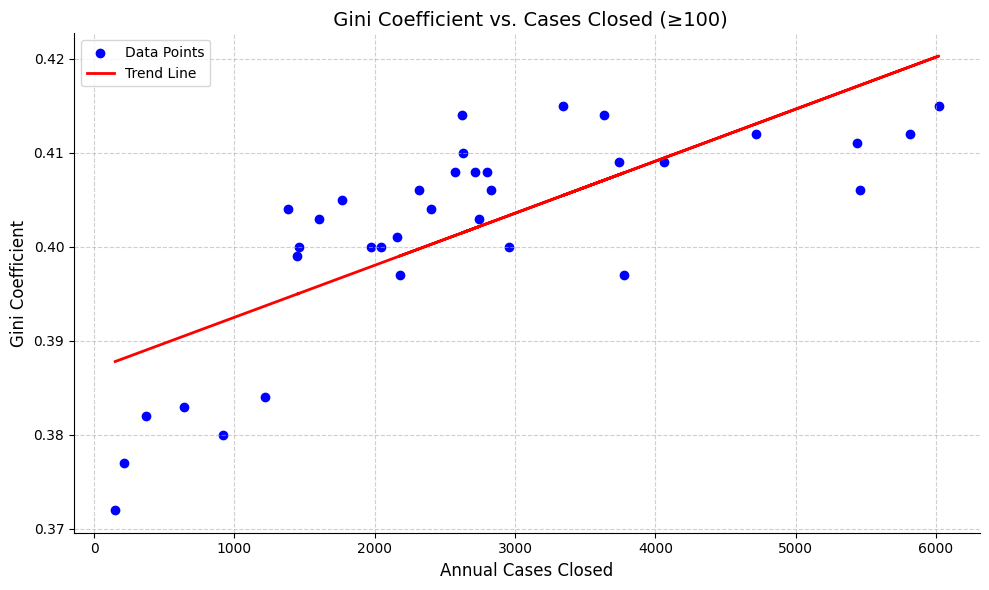

In [17]:
#plotting inequality against annual cases closed
filtered_data = complete_merged[complete_merged['Cases Closed'] >= 100]
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Cases Closed'], filtered_data['Gini Coeff.'], marker='o', color='blue', label='Data Points')
slope, intercept, r_value, p_value, std_err = linregress(filtered_data['Cases Closed'], filtered_data['Gini Coeff.'])
trend_line = slope * filtered_data['Cases Closed'] + intercept
plt.plot(filtered_data['Cases Closed'], trend_line, color='red', linestyle='-', linewidth=2, label='Trend Line')
plt.title(' Gini Coefficient vs. Cases Closed (≥100)', fontsize=14)
plt.xlabel('Annual Cases Closed', fontsize=12)
plt.ylabel('Gini Coefficient', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()
plt.tight_layout()
plt.show()

The scatter plot above shows the Gini Coefficient(measure of income inequality), plotted against Annual Cases Closed. As shown by the trendline there is a clear positive relationship between annual cases closed and inequality. This could be due to the effect of case judgements, at the time of closing, leading to a high degree of market power and concentration and income. However, there is also a lot of variation or noise in the plot, due to other factors influencing inequalty.

On a whole, this figure resembles the main message of our research- that patent ltigiations could be weaponaized by firms leading to concentrated markets and exacerbated wealth inequality. To isolate a reliable causal effect however, we need to account for endogeneity bias using an instrumental variable design, for example.

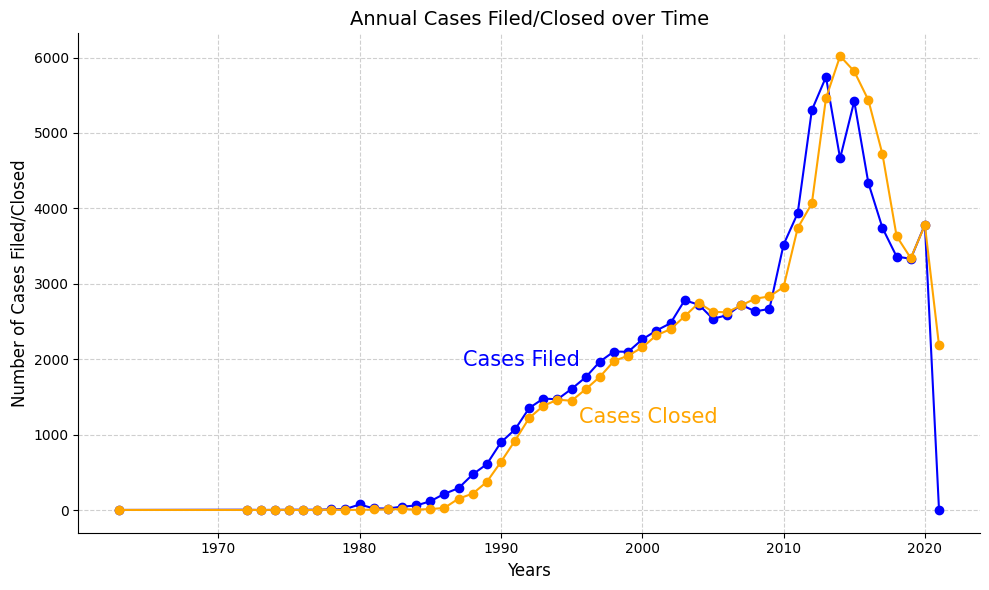

In [22]:
#plotting cases filed and closed over time
plt.figure(figsize=(10, 6))
plt.plot(complete_merged.index, complete_merged['Cases Filed'],  marker='o', linestyle='-', color='blue')
plt.annotate('Cases Filed', (1995, 2000), textcoords="offset points", xytext=(-36,-5), ha='center', color="blue", fontsize=15)
plt.plot(complete_merged.index, complete_merged['Cases Closed'],  marker='o', linestyle='-', color='orange')
plt.annotate('Cases Closed', (1995, 700), textcoords="offset points", xytext=(55, 25), ha='center', color='orange', fontsize=15)
plt.title(f'Annual Cases Filed/Closed over Time', fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Number of Cases Filed/Closed', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

The plot of Cases Filed and Closed Over Time also tells an interesting story.
As shown on the plot above, both annual cases filed and closed follow each other very closely, with a very slight lag on the cases closed data. This is highly suggestive of the fact that most cases are closed very quickly, around a year or two after filing, though since the data is aggregated by year, it doesn't give an exact estimate.

The fact that the vast majority of cases are settled so quickly could be a sign that they are either very simple cases or they aren't supported by a lot of evidence, meaning that they could be filed just for the sake of fighting competitors.

In order to be sure of these, we need to look at the distribution of litigation length.

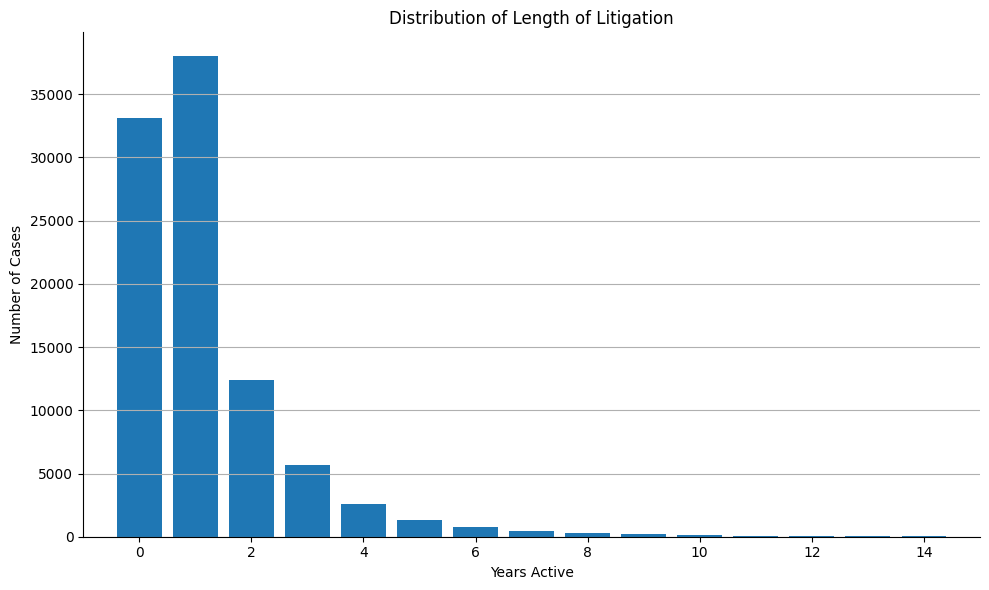

In [23]:
#plotting thedistribution of the length of litigation (years between case filing and closing)
years_active_counts = (clean_cases['year_closed'] - clean_cases['year_filed']).value_counts()
plt.figure(figsize=(10, 6))
plt.bar(years_active_counts.index, years_active_counts.values)
plt.title('Distribution of Length of Litigation')
plt.xlabel('Years Active')
plt.ylabel('Number of Cases')
plt.grid(axis='y')
plt.xlim(-1, 15)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

The distribution of Litigation Length confirms the suggestions from the Cases Filed/Closed over Time plot. The extreme left-skew shows that that the vast majority of cases are closed within 2 years and only a small fraction of patent cases stay in court for longer.

While this seems suggestive of the fact that IPRs are being weaponized by firms to file frivalous suites with the primary goal of burdening their competition with legal costs, it isn't possible to arrive at that conclusion based on the distribution alone.

To further analyze how each case's specifics, we need to include the judgement and any court enforced order/outcomes. Since these documents are stored as text, it would be useful to employ text analysis and natural language processing techniques to interpret and analyze them.

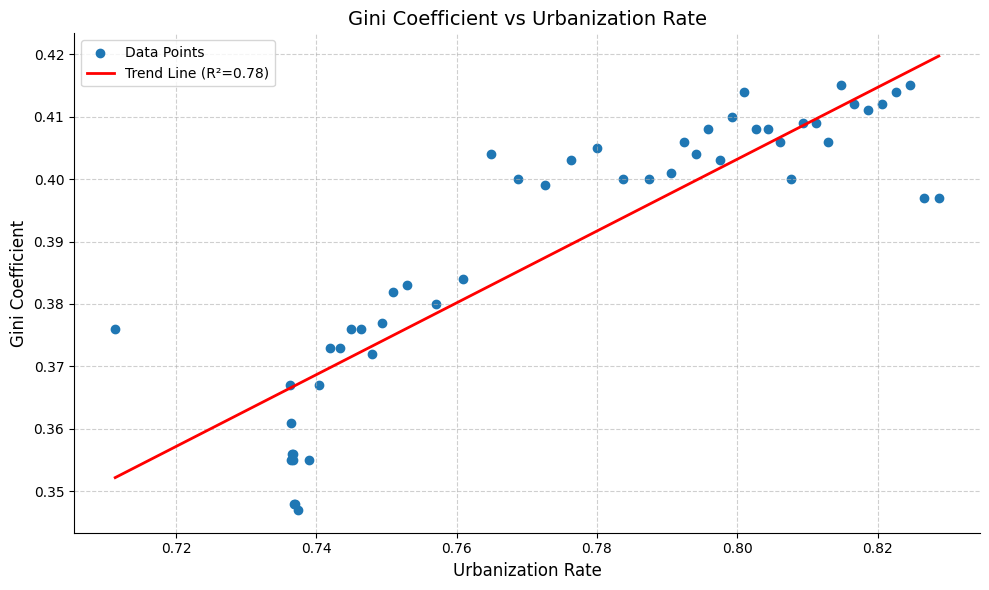

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(complete_merged['Urbanization Rate'], complete_merged['Gini Coeff.'], marker='o', label='Data Points')
slope, intercept, r_value, p_value, std_err = linregress(complete_merged['Urbanization Rate'], complete_merged['Gini Coeff.'])
x_vals = np.linspace(complete_merged['Urbanization Rate'].min(), complete_merged['Urbanization Rate'].max(), 100)
trend_line = slope * x_vals + intercept
plt.plot(x_vals, trend_line, color='red', linestyle='-', linewidth=2, label=f'Trend Line (R²={r_value**2:.2f})')
plt.title('Gini Coefficient vs Urbanization Rate', fontsize=14)
plt.xlabel('Urbanization Rate', fontsize=12)
plt.ylabel('Gini Coefficient', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

As mentioned previously under the correlation heatmap, the Urbanization rates seem to also have a strong positive relationship, with a some variance due error variables.

On a whole, Urbanization rates seem to be a good candidate for a control variables as they can help isolate the variation in inequality due to rural to urban migration.

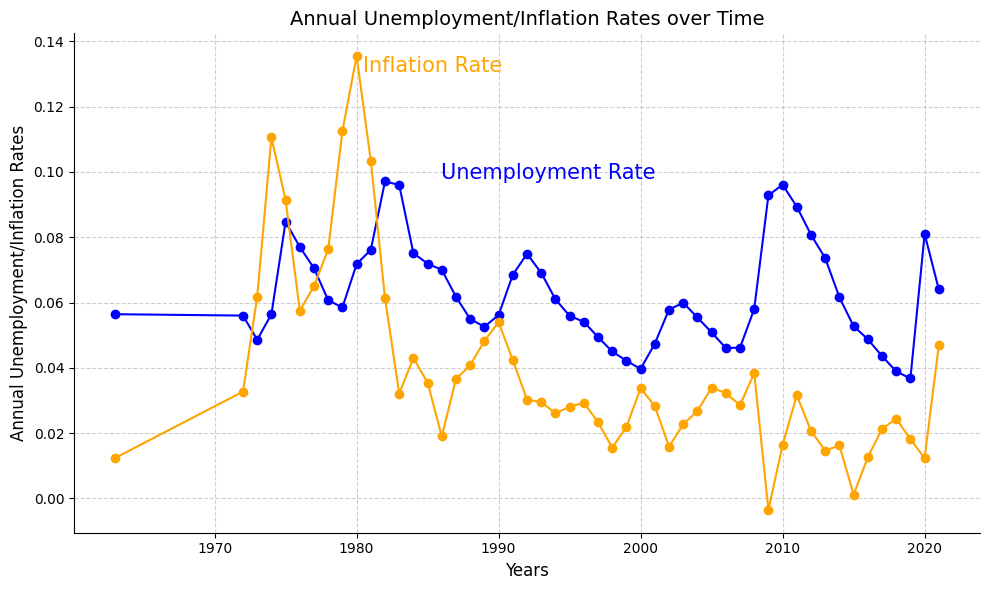

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(complete_merged.index, complete_merged['Unemployment Rate'],  marker='o', linestyle='-', color='blue')
plt.annotate('Unemployment Rate', (1997, 0.10), textcoords="offset points", xytext=(-36,-5), ha='center', color="blue", fontsize=15)
plt.plot(complete_merged.index, complete_merged['Inflation Rate'],  marker='o', linestyle='-', color='orange')
plt.annotate('Inflation Rate', (1980, 0.12), textcoords="offset points", xytext=(55, 25), ha='center', color='orange', fontsize=15)
plt.title(f'Annual Unemployment/Inflation Rates over Time', fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Annual Unemployment/Inflation Rates', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

With the Annualized Unemployment and Inflation Rates, there seems to be a lot of cyclical changes that could be reflective of larger economic patterns. Over the entire 50 year timeframe, Unemployment Rate seem to be within the range of 4-10%, with no long term trend emerging, unlike the Urbanization Rate. Inflation Rates are also fluctuate in cyclical manner and for the most part, tend to fall between 0-6%.

While we initially expected both of these variables to be able to explain some of the year-by-year fluctuations in the inequality data, the negative correlations from the heat map suggest that annualizing may have to lead to excessive loss of information in Unemployment and Inflation.

Plotting them togther, we observe some weak patterns of high unemployment in years with low inflation, particularly between 1985 to 2020. This could just be due to the fact that in years with recessions, the Fed sets higher interest rates which reduce short-run output and inflation, but make it expensive for firms to borrow and thus raise unemployment. So this pattern can likely be attributed to effective Monetary Policy.

Section - 5: Conclusion

Based on this exploratory analysis, we can see promising correlations between patent litigations and inequality. We saw that the vast majority of the patent cases from the USTPO data seem to be resolved in under 2 years, this could be suggestive of frivolous suites being filed as a means of reducing market competition.

We also examined the suitability of potential control variables including annual Urbanization, Unemployment and Inflation rates. Unfortunately only Urbanization seems to be a useful, with regards to better isolating the effect of Patent Litigations on Inequality.

However, at this stage all of our findings are mere correlations and do not constitute a causal effect as they could be entirely spurious. Going forward, implementing an Instrumental Variable Design or a Causal Machine Learning technique to isolate a reliable causal effect.

References:


*   Dam, Kenneth W. 2002. The Economic Underpinnings of Patent Law. Chicago: University of Chicago Law School.
https://chicagounbound.uchicago.edu/cgi/viewcontent.cgi?article=1508&context=law_and_economics

*   Maskus, Keith E. 2022. Intellectual Property Rights and Economic Inequality: Theory and Evidence. Stockholm Intellectual Property Law Review, Vol. 5, Issue 1, September 2022.

*   Kapczynski, Amy. 2015. "Four Hypotheses on Intellectual Property and Inequality." Yale Law School Legal Scholarship Repository.
https://law.yale.edu/sites/default/files/documents/pdf/SELA15_Kapczynski_CV_Eng.pdf

*  Drahos, Peter, and Susy Frankel. 2022. Intellectual Property, Innovation, and Economic Inequality. Cambridge: Cambridge University Press.
https://www.cambridge.org/core/books/intellectual-property-innovation-and-economic-inequality/15F8912E63C4C397E0071E8F29B5B54B

*   Saini, S. S., and Meenakshi Mehra. 2018. "Impact of Strengthening Intellectual Property Rights Regime on Income Inequality: A Dynamic Panel Data Analysis." Economics Bulletin 38 (2): 1013-1023.

estimated word count: 1452